# Covid-19 Analysis

In [ ]:
!pip install imutils

In [99]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np
import pandas as pd 
import sys
import os
import cv2
import os.path
import random
import shutil

from pathlib import Path
from imutils import paths


# image processing
import imageio
import skimage
import skimage.io
import skimage.transform

# Charts
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns


# ML
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics

#from sklearn.preprocessing import OneHotEncoder
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
import tensorflow

#####################################
# Settings
#####################################
#plt.style.use('ggplot')



## Data Preparation  
Our goal is to try to automate the classification of covid-19 x-rays images against others.  

The dataset contains set of x-ray images from "healthy" patients, and "unhealthy" patients. The unhealthy group is a classified set of multiple repiratory illnesses, such as pnemonia and covid-19. 


#### Set Paths

In [142]:
dataset_path = './dataset'

In [143]:
%%bash
rm -rf dataset
mkdir -p dataset/covid
mkdir -p dataset/normal

#### Load Data

In [144]:
# Prep Metadata csv from the covid-19 dataset
# construct the path to the metadata CSV file for covid19 and load it
covid_dataset_path = '../input/covid-chest-xray'
csv_covid_path = os.path.sep.join([covid_dataset_path, "metadata.csv"])
meta_df = pd.read_csv(csv_covid_path)


In [156]:
print("\ncovid-19 dataframe:\n")
print("\ndataframe column variables available: \n{}\n".format(meta_df.columns.values))
print("\nunique views: {}\n".format(meta_df['view'].unique()))
print("\nunique findings: {}\n".format(meta_df['finding'].unique()))
meta_df.info()

meta_df.head()


covid-19 dataframe:


dataframe column variables available: 
['Patientid' 'offset' 'sex' 'age' 'finding' 'survival' 'view' 'modality'
 'date' 'location' 'filename' 'doi' ' url' 'license' 'clinical notes'
 'other notes' 'Unnamed: 16']


unique views: ['PA' 'L' 'AP' 'Axial' 'AP Supine' 'Coronal']


unique findings: ['COVID-19' 'ARDS' 'SARS' 'Pneumocystis' 'Streptococcus' 'No Finding']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 17 columns):
Patientid         146 non-null int64
offset            108 non-null float64
sex               127 non-null object
age               121 non-null float64
finding           146 non-null object
survival          59 non-null object
view              146 non-null object
modality          146 non-null object
date              146 non-null object
location          113 non-null object
filename          146 non-null object
doi               76 non-null object
 url              146 non-null object
license       

,Patientid,offset,sex,age,finding,survival,view,modality,date,location,filename,doi,url,license,clinical notes,other notes,Unnamed: 16
0,2,0.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
1,2,3.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
2,2,5.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
3,2,6.0,M,65.0,COVID-19,Y,PA,X-ray,2020,NaN,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,NaN,NaN,NaN
4,4,0.0,F,52.0,COVID-19,NaN,PA,X-ray,2020,"Changhua Christian Hospital, Changhua City, Ta...",nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


In [157]:
covid_df = meta_df.loc[meta_df['finding']=='COVID-19']
other_df = meta_df.loc[meta_df['finding']!='COVID-19']

### Load x-ray image paths

**Covid 19 Images **

In [158]:

# Load the covid-19 x-ray images 
for (i, row) in meta_df.iterrows():
    # condition -
    # if the current case is not COVID-19,
    # or this is not a 'PA' view, then ignore the row
    if row["finding"] != "COVID-19" or row["view"] != "PA":
        continue

    # build the path to the input image file
    # if the input image file does not exist ignore the row
    imagePath = os.path.sep.join([covid_dataset_path, "images", row["filename"]])
    if not os.path.exists(imagePath):
        continue

    # extract the filename from the image path, construct the path, copy the image 
    filename = row["filename"].split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/covid", filename])
    shutil.copy2(imagePath, outputPath)

In [159]:
covid_images = list(paths.list_images(f"{dataset_path}/covid"))


In [160]:
len(covid_images)

69

**Normal Images**

In [163]:

# Load the normal x-ray images from the chest x-ray dataset
# load normal x-ray images here

pneumonia_dataset_path = '../input/chest-xray-pneumonia'

samples = 69
base_path = os.path.sep.join([pneumonia_dataset_path, "chest_xray/train", "NORMAL"])
image_paths = list(paths.list_images(base_path))
# randomly sample the image paths
random.seed(42)
random.shuffle(image_paths)
image_paths = image_paths[:samples]

# loop over the image paths
for (i, image_path) in enumerate(image_paths ):
    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = image_path.split(os.path.sep)[-1]
    output_path = os.path.sep.join([f"{dataset_path}/normal", filename])
    # copy the image
    shutil.copy2(image_path, output_path)


In [164]:
normal_images = list(paths.list_images(f"{dataset_path}/normal"))

In [165]:
len(normal_images)

69

### Inspect Data

In [166]:
print(other_df['finding'].unique())
print(covid_df['finding'].unique())

['ARDS' 'SARS' 'Pneumocystis' 'Streptococcus' 'No Finding']
['COVID-19']


In [167]:
covid_df.shape
other_df.shape

(25, 17)

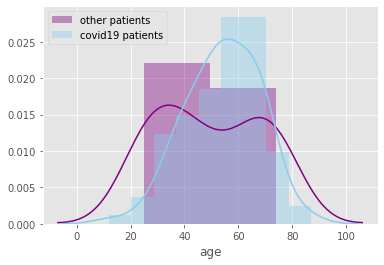

In [168]:
# Import library and dataset
import matplotlib.pyplot as plt 

import seaborn as sns

 
# Method 1: on the same Axis
sns.distplot( other_df['age'] , color="purple", label="other patients")
sns.distplot( covid_df['age'] , color="skyblue", label="covid19 patients")

plt.legend()
plt.show()

## Add more EDA here  
Relationships b/w vars   
offset time and survival rate? age and sex? ...etc.


### View dataset x-ray images

In [169]:
# plot the images

def ceildiv(a, b):
    return -(-a // b)

def plot_xray_imgs(img_paths, figsize=(20,15), rows=1, titles=None, title=None):
    fig = plt.figure(figsize=figsize)
    if title is not None: plt.suptitle(title, fontsize=20)
    for i in range(len(img_paths)):
        sub_plot = fig.add_subplot(rows, ceildiv(len(img_paths), rows), i+1)
        sub_plot.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        img = plt.imread(img_paths[i])
        plt.imshow(img)

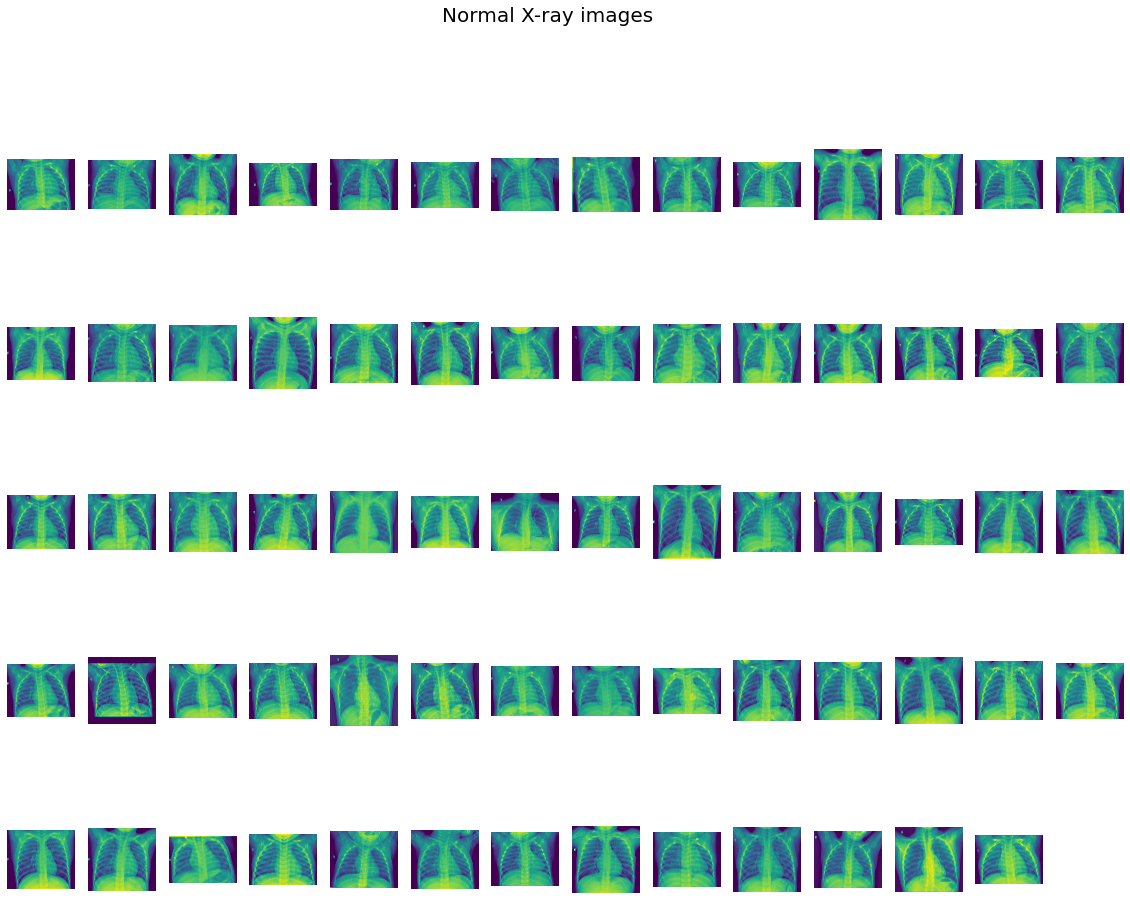

In [170]:
plot_xray_imgs(normal_images, rows=5, title="Normal X-ray images")

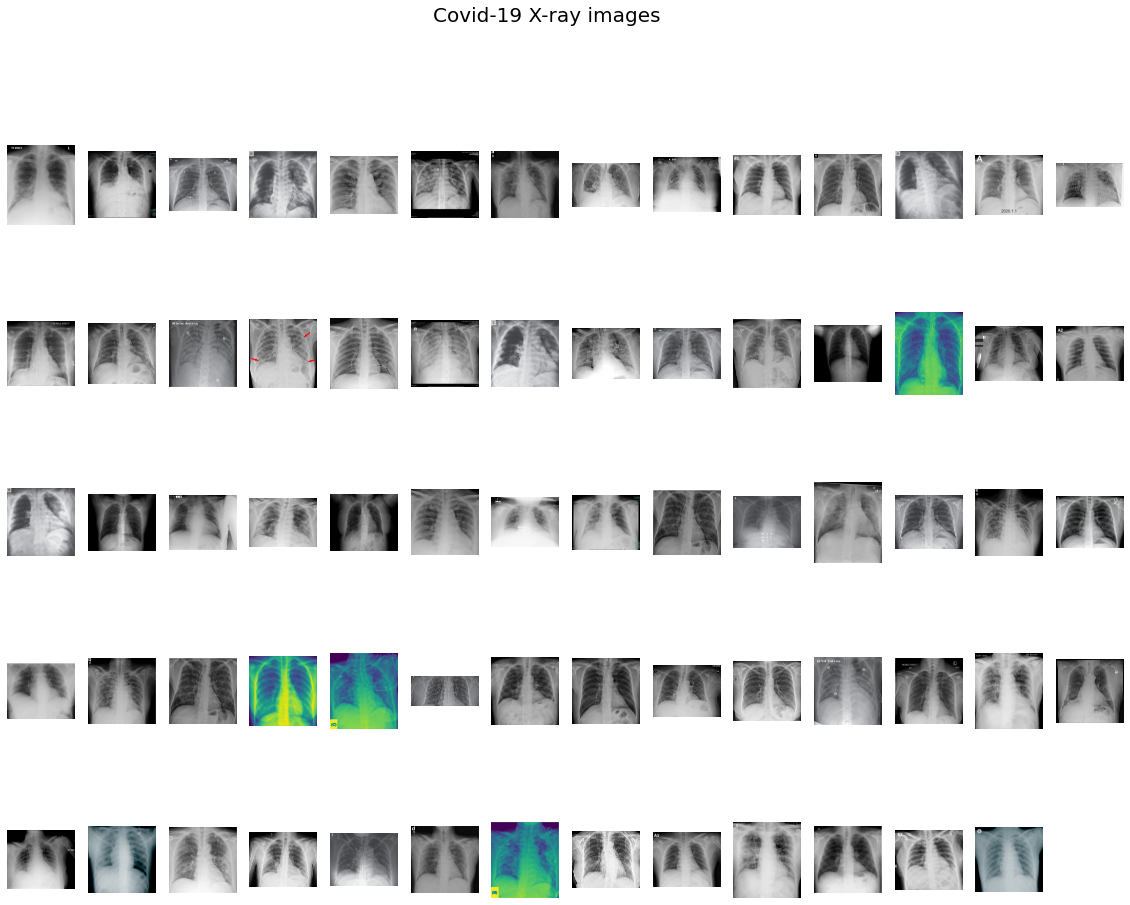

In [171]:
plot_xray_imgs(covid_images, rows=5, title="Covid-19 X-ray images")